In [3]:
#from langchain_experimental.agents import create_pandas_dataframe_agent
import os
import json
import openai
from openai import AzureOpenAI
#from langchain.llms import AzureOpenAI
#from langchain_openai import AzureChatOpenAI
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import CausalInference

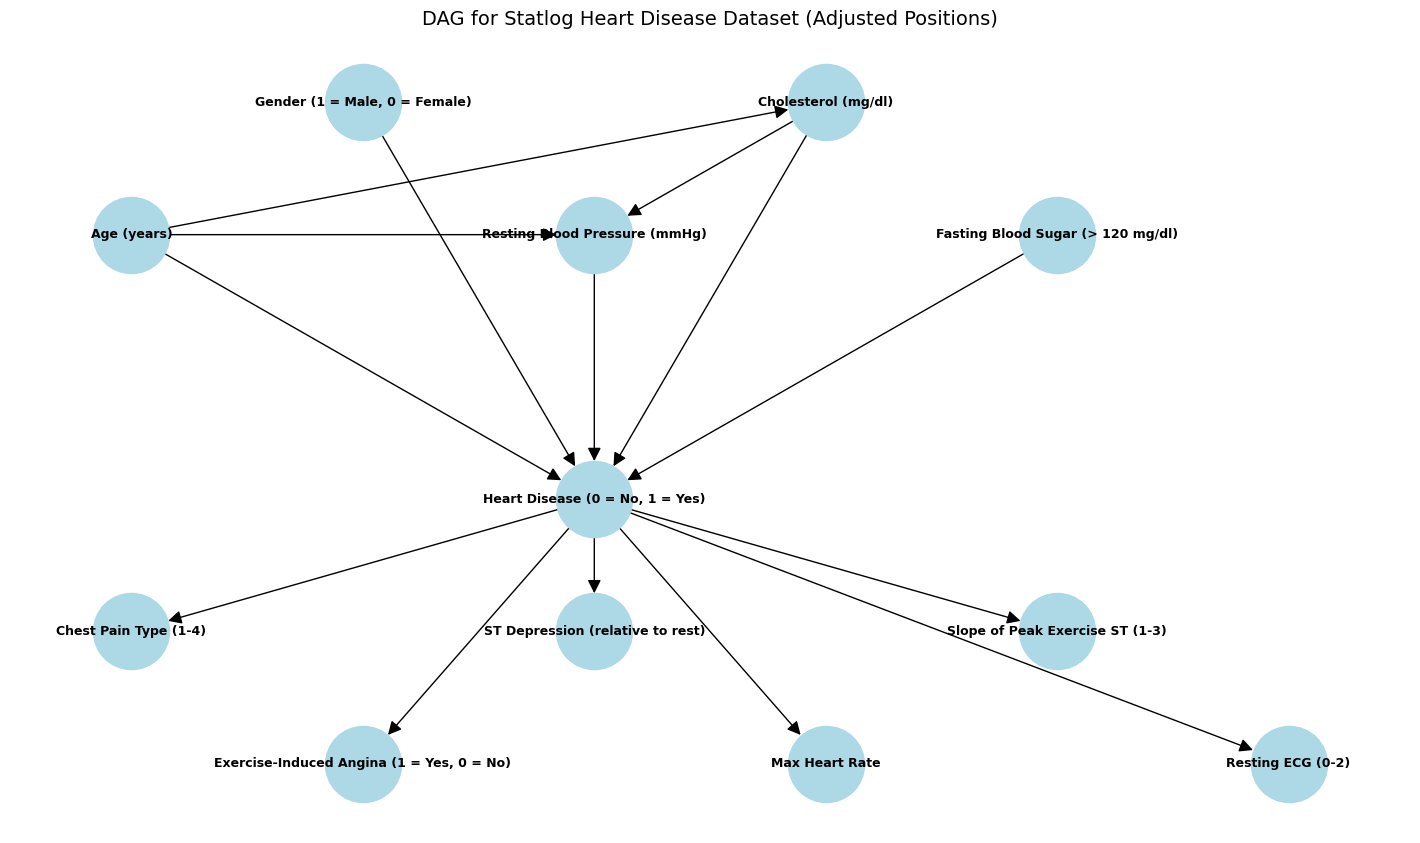

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
G = nx.DiGraph()

# Define the variables from the dataset description
nodes = {
    "age": "Age (years)",
    "sex": "Gender (1 = Male, 0 = Female)",
    "cp": "Chest Pain Type (1-4)",
    "trestbps": "Resting Blood Pressure (mmHg)",
    "chol": "Cholesterol (mg/dl)",
    "fbs": "Fasting Blood Sugar (> 120 mg/dl)",
    "restecg": "Resting ECG (0-2)",
    "thalach": "Max Heart Rate",
    "exang": "Exercise-Induced Angina (1 = Yes, 0 = No)",
    "oldpeak": "ST Depression (relative to rest)",
    "slope": "Slope of Peak Exercise ST (1-3)",
    "target": "Heart Disease (0 = No, 1 = Yes)",
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges based on causal relationships
edges = [
    # Risk factors directly influencing heart disease
    ("age", "target"),
    ("sex", "target"),
    ("trestbps", "target"),
    ("chol", "target"),
    ("fbs", "target"),

    # Symptoms influenced by heart disease
    ("target", "cp"),
    ("target", "exang"),
    ("target", "oldpeak"),
    ("target", "thalach"),
    ("target", "slope"),
    ("target", "restecg"),

    # Interactions among risk factors
    ("age", "trestbps"),  # Age affects blood pressure
    ("age", "chol"),      # Age affects cholesterol
    ("chol", "trestbps"), # Cholesterol affects blood pressure
]

# Add edges to the graph
G.add_edges_from(edges)

# Define node positions for better visualization
pos = {
    "age": (0, 3),
    "sex": (1, 3),
    "trestbps": (2, 3),
    "chol": (3, 3),
    "fbs": (4, 3),
    "target": (2, 2),
    "cp": (0, 1),
    "exang": (1, 1),
    "oldpeak": (2, 1),
    "thalach": (3, 1),
    "slope": (4, 1),
    "restecg": (5, 1),
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, labels=nodes, node_size=3000, 
    node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20
)
plt.title("DAG for Statlog Heart Disease Dataset", fontsize=14)
plt.show()


In [4]:
import pandas as pd
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        try:
            df = pd.read_csv(self.file_path)
            print("Data loaded successfully.")
            df =  df.dropna()
            df = df[df['chol'] >=0]
            df = df[df['trestbps'] !=0]
            return df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

In [6]:
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_train = dataLoader.load_data()
data_binner = DataBinner(df_train)
df_binned = data_binner.apply_binning()

Data loaded successfully.


In [7]:

dataLoader_ = DataLoader("df_high_risk_tp.csv")
df_test = dataLoader_.load_data()
data_binner_ = DataBinner(df_test)
df_binned_ = data_binner_.apply_binning()

Data loaded successfully.


In [8]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import CausalInference

class BayesianNetworkModel:
    def __init__(self):
        self.model = None
        self.causal_inference = None

    def define_structure(self):
        self.model = BayesianNetwork([  ('age', 'target'),
                                        ('sex', 'target'),
                                        ('chol', 'target'),
                                        ('fbs', 'target'),
                                        ('trestbps', 'target'),

                                        # Diseases -> Symptoms
                                        ('target', 'cp'),
                                        ('target', 'restecg'),
                                        ('target', 'thalach'),
                                        ('target', 'exang'),
                                        ('target', 'slope'),
                                        ('target', 'oldpeak'),

                                        # Direct Risk Factors -> Symptoms relationships
                                        ('age', 'chol'),
                                        ('age', 'trestbps'),
                                        ('sex', 'trestbps'),
                                        ('sex', 'chol'),
                                        ('chol', 'trestbps'),
                                        ('thalach', 'exang'),
                                        ('exang', 'cp')])

    def fit_model(self, data):
        if self.model is None:
            raise ValueError("Model structure is not defined. Call define_structure() first.")
        self.model.fit(data, estimator=MaximumLikelihoodEstimator)
        print("Model fitted successfully.")

    def initialize_causal_inference(self):
        if self.model is None:
            raise ValueError("Model is not defined. Call define_structure() and fit_model() first.")
        self.causal_inference = CausalInference(self.model)
        print("Causal inference initialized successfully.")

    def get_model(self):
        return self.model

    def get_causal_inference(self):
        return self.causal_inference


In [9]:
'''from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import CausalInference

class BayesianNetworkModel:
    def __init__(self):
        self.model = None
        self.causal_inference = None

    def define_structure(self):
        self.model = BayesianNetwork([("age", "chol"),
                                      ("age", "trestbps"),
                                      ("sex", "chol"),
                                      ("sex", "trestbps"),
                                      ("sex", "target"),
                                      ("cp", "target"),
                                      ("trestbps", "target"),
                                      ("chol", "target"),
                                      ("fbs", "target"),
                                      ("restecg", "target"),
                                      ("thalach", "target"),
                                      ("thalach", "exang"),
                                      ("exang", "target"),
                                      ("oldpeak", "target"),
                                      ("oldpeak", "exang"),
                                      ("slope", "target"),
                                      ("slope", "exang")])

    def fit_model(self, data):
        if self.model is None:
            raise ValueError("Model structure is not defined. Call define_structure() first.")
        self.model.fit(data, estimator=MaximumLikelihoodEstimator)
        print("Model fitted successfully.")

    def initialize_causal_inference(self):
        if self.model is None:
            raise ValueError("Model is not defined. Call define_structure() and fit_model() first.")
        self.causal_inference = CausalInference(self.model)
        print("Causal inference initialized successfully.")

    def get_model(self):
        return self.model

    def get_causal_inference(self):
        return self.causal_inference'''


'from pgmpy.models import BayesianNetwork\nfrom pgmpy.estimators import MaximumLikelihoodEstimator\nfrom pgmpy.inference import CausalInference\n\nclass BayesianNetworkModel:\n    def __init__(self):\n        self.model = None\n        self.causal_inference = None\n\n    def define_structure(self):\n        self.model = BayesianNetwork([("age", "chol"),\n                                      ("age", "trestbps"),\n                                      ("sex", "chol"),\n                                      ("sex", "trestbps"),\n                                      ("sex", "target"),\n                                      ("cp", "target"),\n                                      ("trestbps", "target"),\n                                      ("chol", "target"),\n                                      ("fbs", "target"),\n                                      ("restecg", "target"),\n                                      ("thalach", "target"),\n                                      ("thalach"

In [10]:

# Assuming df_binned is your binned DataFrame
bayesian_network_model = BayesianNetworkModel()
bayesian_network_model.define_structure()
bayesian_network_model.fit_model(df_binned)
bayesian_network_model.initialize_causal_inference()

# Access the model and causal inference objects if needed
model = bayesian_network_model.get_model()
causal_inference = bayesian_network_model.get_causal_inference()

Model fitted successfully.
Causal inference initialized successfully.


In [11]:
intervene_model=model.do(['trestbps'])


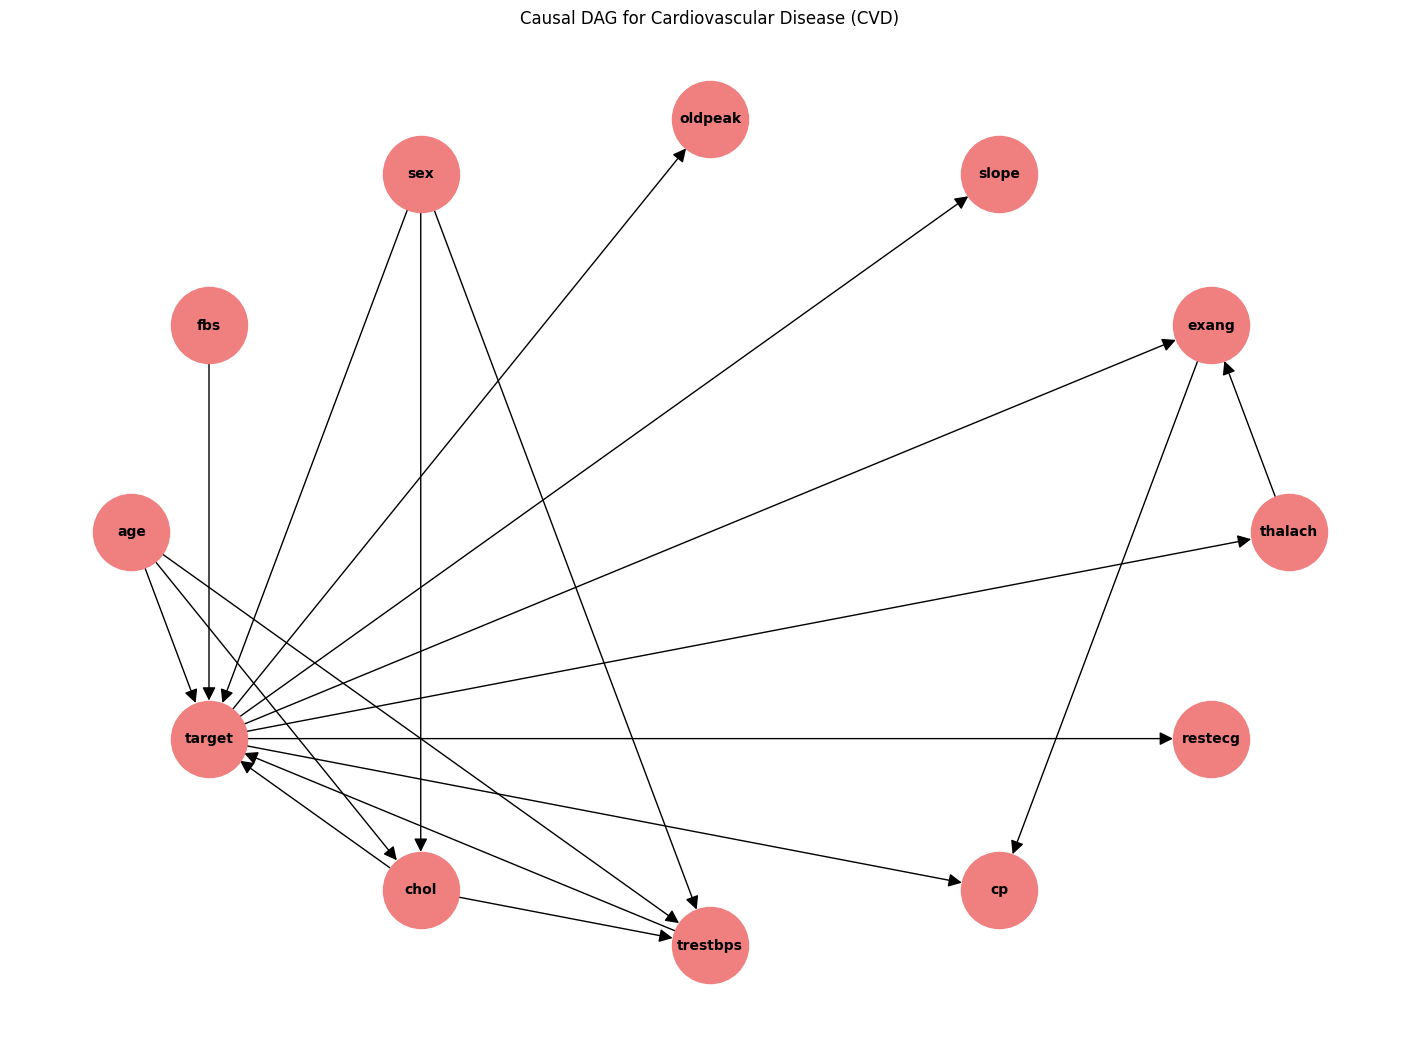

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a NetworkX graph from the model's edges
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.shell_layout(G)
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightcoral',
    font_size=10, font_weight='bold', arrowsize=20
)

# Display the graph
plt.title('Causal DAG for Cardiovascular Disease (CVD)')
plt.show()

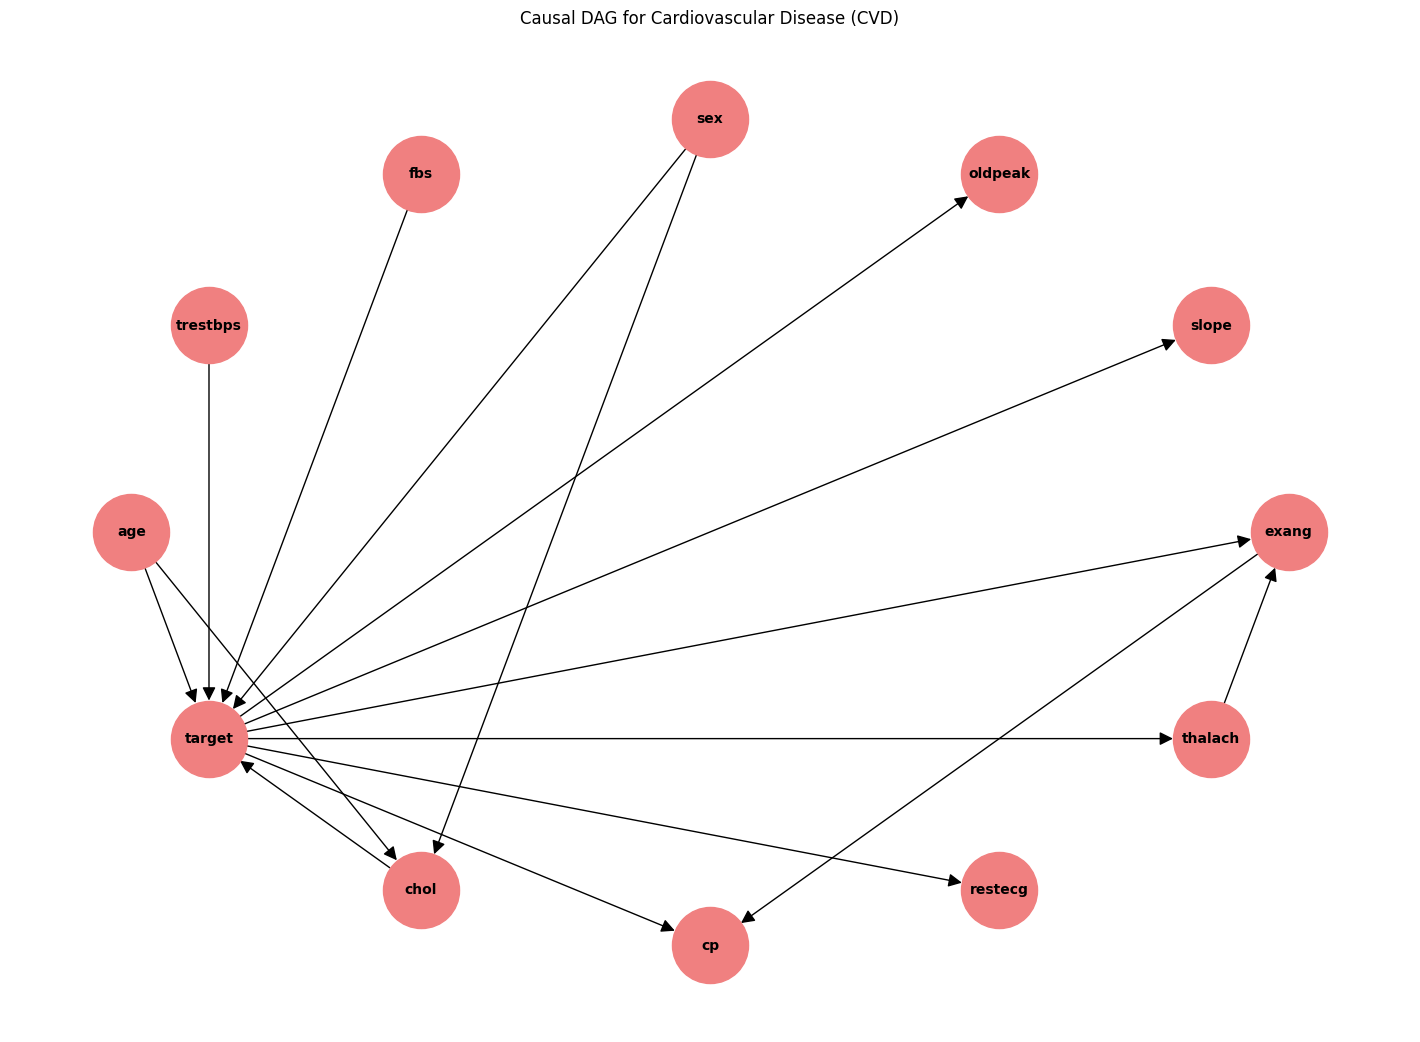

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a NetworkX graph from the model's edges
G = nx.DiGraph()
G.add_edges_from(intervene_model.edges())

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.shell_layout(G)
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightcoral',
    font_size=10, font_weight='bold', arrowsize=20
)

# Display the graph
plt.title('Causal DAG for Cardiovascular Disease (CVD)')
plt.show()

In [14]:
# Check for NaN values in test_data
nan_rows = df_train[df_train.isna().any(axis=1)]
print(f"Rows with NaN values in test_data:\n{nan_rows}")

Rows with NaN values in test_data:
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, target, age_bin, chol_bin, trestbps_bin, thalach_bin, oldpeak_bin]
Index: []


In [15]:
# Check for NaN values in test_data
nan_rows = df_binned[df_binned.isna().any(axis=1)]
print(f"Rows with NaN values in test_data:\n{nan_rows}")

Rows with NaN values in test_data:
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, target]
Index: []


In [16]:
df_binned[df_binned['target'] == 1].iloc[1]

age         2
sex         0
cp          4
trestbps    2
chol        1
fbs         0
restecg     0
thalach     1
exang       1
oldpeak     1
slope       2
target      1
Name: 3, dtype: int64

In [17]:
# Filter the DataFrame to find a row where target is 1
target_1_row = df_binned[df_binned['target'] == 1].iloc[1]

# Create an evidence dictionary from the selected row with discretized values
evidence = {
    'age': target_1_row['age'],
    'sex': target_1_row['sex'],
    'chol': target_1_row['chol'],
    'trestbps': target_1_row['trestbps'],
    'cp': target_1_row['cp'],
    'fbs': target_1_row['fbs'],
    'restecg': target_1_row['restecg'],
    'thalach': target_1_row['thalach'],
    'exang': target_1_row['exang'],
    'oldpeak': target_1_row['oldpeak'],
    'slope': target_1_row['slope']
}


In [18]:
target_1_row

age         2
sex         0
cp          4
trestbps    2
chol        1
fbs         0
restecg     0
thalach     1
exang       1
oldpeak     1
slope       2
target      1
Name: 3, dtype: int64

In [19]:
evidence

{'age': 2,
 'sex': 0,
 'chol': 1,
 'trestbps': 2,
 'cp': 4,
 'fbs': 0,
 'restecg': 0,
 'thalach': 1,
 'exang': 1,
 'oldpeak': 1,
 'slope': 2}

In [20]:
intervention = {'chol':0}

In [21]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)

print("Target distribution after intervention:")
print(target_distribution_after)

  0%|          | 0/1 [00:00<?, ?it/s]

Target distribution before intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.1164 |
+-----------+---------------+
| target(1) |        0.8836 |
+-----------+---------------+
Target distribution after intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.8599 |
+-----------+---------------+
| target(1) |        0.1401 |
+-----------+---------------+


True Positive Examples

In [ ]:
'''# Apply binning functions to the respective columns
df_high_risk_tp['age_bin'] = df_high_risk_tp['age'].apply(bin_age)
df_high_risk_tp['chol_bin'] = df_high_risk_tp['chol'].apply(bin_chol)
df_high_risk_tp['trestbps_bin'] = df_high_risk_tp['trestbps'].apply(bin_trestbps)
df_high_risk_tp['thalach_bin'] = df_high_risk_tp['thalach'].apply(bin_thalach)
df_high_risk_tp['oldpeak_bin'] = df_high_risk_tp['oldpeak'].apply(bin_oldpeak)

# Create a new DataFrame with the binned column values
df_binned_tp = df_high_risk_tp.copy(deep=True)
df_binned_tp['age'] = df_binned_tp['age_bin']
df_binned_tp['chol'] = df_binned_tp['chol_bin']
df_binned_tp['trestbps'] = df_binned_tp['trestbps_bin']
df_binned_tp['thalach'] = df_binned_tp['thalach_bin']
df_binned_tp['oldpeak'] = df_binned_tp['oldpeak_bin']

# Drop the temporary binned columns
df_binned_tp.drop(columns=['age_bin', 'chol_bin', 'trestbps_bin', 'thalach_bin', 'oldpeak_bin'], inplace=True)

# Display the first few rows of the binned DataFrame
print(df_binned_tp.head())'''

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0    3    1   1         4     2    0        2        1      0        0      1   
1    3    1   3         3     1    0        0        3      0        0      2   
2    3    0   4         4     3    0        1        1      1        3      2   
3    3    1   4         3     1    0        0        1      1        2      2   
4    3    1   4         2     3    1        2        1      1        1      3   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [22]:
# Filter the DataFrame to find a row where target is 1
target_1_row = df_binned_[df_binned_['target'] == 1].iloc[3]

# Create an evidence dictionary from the selected row with discretized values
evidence = {
    'age': target_1_row['age'],
    'sex': target_1_row['sex'],
    'chol': target_1_row['chol'],
    'trestbps': target_1_row['trestbps'],
    'cp': target_1_row['cp'],
    'fbs': target_1_row['fbs'],
    'restecg': target_1_row['restecg'],
    'thalach': target_1_row['thalach'],
    'exang': target_1_row['exang'],
    'oldpeak': target_1_row['oldpeak'],
    'slope': target_1_row['slope']
}


In [23]:
evidence

{'age': 3,
 'sex': 1,
 'chol': 1,
 'trestbps': 3,
 'cp': 4,
 'fbs': 0,
 'restecg': 0,
 'thalach': 1,
 'exang': 1,
 'oldpeak': 2,
 'slope': 2}

In [24]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)


# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)



Target distribution before intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.0027 |
+-----------+---------------+
| target(1) |        0.9973 |
+-----------+---------------+


In [25]:
# Get the CPDs for each variable in the evidence dictionary
cpds_evidence = {var: model.get_cpds(var) for var in evidence.keys()}

# Print the CPDs for each evidence variable
for var, cpd in cpds_evidence.items():
    print(f"CPD of {var}:")
    print(cpd)
    print("\n")


CPD of age:
+--------+------------+
| age(0) | 0.00420521 |
+--------+------------+
| age(1) | 0.0731707  |
+--------+------------+
| age(2) | 0.234651   |
+--------+------------+
| age(3) | 0.404542   |
+--------+------------+
| age(4) | 0.283431   |
+--------+------------+


CPD of sex:
+--------+----------+
| sex(0) | 0.236333 |
+--------+----------+
| sex(1) | 0.763667 |
+--------+----------+


CPD of chol:
+---------+--------+--------+-----+---------------------+--------+
| age     | age(0) | age(0) | ... | age(4)              | age(4) |
+---------+--------+--------+-----+---------------------+--------+
| sex     | sex(0) | sex(1) | ... | sex(0)              | sex(1) |
+---------+--------+--------+-----+---------------------+--------+
| chol(0) | 0.25   | 0.2    | ... | 0.21839080459770116 | 0.368  |
+---------+--------+--------+-----+---------------------+--------+
| chol(1) | 0.25   | 0.4    | ... | 0.16091954022988506 | 0.228  |
+---------+--------+--------+-----+--------------

In [26]:
intervention = {'chol': 0,'trestbps':2}

In [27]:

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

print("Target distribution after intervention:")
print(target_distribution_after)

  0%|          | 0/1 [00:00<?, ?it/s]

Target distribution after intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5055 |
+-----------+---------------+
| target(1) |        0.4945 |
+-----------+---------------+


In [29]:
from copy import deepcopy
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
# Step 2: Perform the Intervention
intervened_model = deepcopy(model)

# Remove edges into 'chol' to reflect the intervention
intervened_model.remove_edge('age', 'chol')
intervened_model.remove_edge('sex', 'chol')

# Modify the CPD of 'chol'
original_cpd_chol = model.get_cpds('chol')
state_names_chol = original_cpd_chol.state_names['chol']
variable_card_chol = original_cpd_chol.variable_card
intervened_state = state_names_chol[0]  # Set 'chol' to the first state

intervened_values = [[1.0 if state == intervened_state else 0.0] for state in state_names_chol]

intervened_cpd_chol = TabularCPD(
    variable='chol',
    variable_card=variable_card_chol,
    values=intervened_values,
    state_names={'chol': state_names_chol}
)

intervened_model.remove_cpds('chol')
intervened_model.add_cpds(intervened_cpd_chol)
assert intervened_model.check_model()

# Step 3: Re-Learn the CPDs of Descendants
descendants = nx.descendants(intervened_model, 'chol')

# Generate data from the intervened model
sampler = BayesianModelSampling(intervened_model)
intervened_data = sampler.forward_sample(size=10000, seed=42)

# Re-fit the CPDs of the descendants
intervened_model.fit(
    intervened_data,
    estimator=MaximumLikelihoodEstimator,
 
)
assert intervened_model.check_model()

# Step 4: Access and Display the Updated CPDs
for node in descendants:
    cpd = intervened_model.get_cpds(node)
    print(f"CPD of {node} after intervention:")
    print(cpd)
    print()

  0%|          | 0/12 [00:00<?, ?it/s]

CPD of trestbps after intervention:
+-------------+---------------------+-----+---------------------+
| age         | age(0)              | ... | age(4)              |
+-------------+---------------------+-----+---------------------+
| chol        | chol(0)             | ... | chol(0)             |
+-------------+---------------------+-----+---------------------+
| sex         | sex(0)              | ... | sex(1)              |
+-------------+---------------------+-----+---------------------+
| trestbps(0) | 0.18181818181818182 | ... | 0.13137632338787295 |
+-------------+---------------------+-----+---------------------+
| trestbps(1) | 0.2727272727272727  | ... | 0.13282001924927817 |
+-------------+---------------------+-----+---------------------+
| trestbps(2) | 0.18181818181818182 | ... | 0.29884504331087586 |
+-------------+---------------------+-----+---------------------+
| trestbps(3) | 0.18181818181818182 | ... | 0.3041385948026949  |
+-------------+---------------------+---

In [49]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD


def do(model: BayesianNetwork, interventions: dict):
    """ 
    Implement an ideal intervention for discrete variables. Modifies pgmpy's
    `do` method so it is a `do`-operator, meaning a function that takes in a
    model, modifies it with an ideal intervention, and returns a new model.
    Note that this code would need to be modified to work for continuous
    variables.
    """
    def _mod_kernel(kernel: TabularCPD, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """ 
        var_name = kernel.variable
        card = kernel.get_cardinality([var_name])[var_name]
        states = [kernel.get_state_names(var_name, i) for i in range(card)]
        non_int_states = set(states) - {int_val,}
        unordered_prob_vals = [[1.0]] + [[0.0] for _ in range(card - 1)]
        unordered_states = [int_val] + list(non_int_states)
        # Reorder so it matches original
        dict_ = dict(zip(unordered_states, unordered_prob_vals))
        ordered_prob_values = [dict_[k] for k in states]
        intervention_kernel = TabularCPD(
            var_name, card, ordered_prob_values,
            state_names = {var_name: states}
        )
        return intervention_kernel

    kernels = {kern.variable: kern for kern in model.get_cpds()}
    new_model = model.copy()
    for var, int_val in interventions.items():
        new_model = new_model.do(var)
        new_kernel = _mod_kernel(kernels[var], int_val)
        new_model.add_cpds(new_kernel)
    return new_model
    

In [50]:
intervention = {'chol': 0,'trestbps':2}
new_model = do(model, intervention)


In [52]:
for cpd in new_model.get_cpds():
    print(f"CPD of {cpd.variable} after intervention:")
    print(cpd)

CPD of age after intervention:
+--------+------------+
| age(0) | 0.00420521 |
+--------+------------+
| age(1) | 0.0731707  |
+--------+------------+
| age(2) | 0.234651   |
+--------+------------+
| age(3) | 0.404542   |
+--------+------------+
| age(4) | 0.283431   |
+--------+------------+
CPD of target after intervention:
+-----------+-------------+-----+-------------+--------------------+
| age       | age(0)      | ... | age(4)      | age(4)             |
+-----------+-------------+-----+-------------+--------------------+
| chol      | chol(0)     | ... | chol(3)     | chol(3)            |
+-----------+-------------+-----+-------------+--------------------+
| fbs       | fbs(0)      | ... | fbs(1)      | fbs(1)             |
+-----------+-------------+-----+-------------+--------------------+
| sex       | sex(0)      | ... | sex(1)      | sex(1)             |
+-----------+-------------+-----+-------------+--------------------+
| trestbps  | trestbps(0) | ... | trestbps(3) | tr

In [44]:

# Directly access the CPDs for the evidence variables from the model
cpds_evidence_after_intervention = {var: intervene_model.get_cpds(var) for var in evidence.keys()}

# Print the CPDs for each evidence variable after intervention
for var, cpd in cpds_evidence_after_intervention.items():
    print(f"\nCPD of {var} after intervention:")
    print(cpd)


CPD of age after intervention:
+--------+------------+
| age(0) | 0.00420521 |
+--------+------------+
| age(1) | 0.0731707  |
+--------+------------+
| age(2) | 0.234651   |
+--------+------------+
| age(3) | 0.404542   |
+--------+------------+
| age(4) | 0.283431   |
+--------+------------+

CPD of sex after intervention:
+--------+----------+
| sex(0) | 0.236333 |
+--------+----------+
| sex(1) | 0.763667 |
+--------+----------+

CPD of chol after intervention:
+---------+--------+--------+-----+---------------------+--------+
| age     | age(0) | age(0) | ... | age(4)              | age(4) |
+---------+--------+--------+-----+---------------------+--------+
| sex     | sex(0) | sex(1) | ... | sex(0)              | sex(1) |
+---------+--------+--------+-----+---------------------+--------+
| chol(0) | 0.25   | 0.2    | ... | 0.21839080459770116 | 0.368  |
+---------+--------+--------+-----+---------------------+--------+
| chol(1) | 0.25   | 0.4    | ... | 0.16091954022988506 | 0.

In [26]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)

print("Target distribution after intervention:")
print(target_distribution_after)

  0%|          | 0/1 [00:00<?, ?it/s]

Target distribution before intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.0027 |
+-----------+---------------+
| target(1) |        0.9973 |
+-----------+---------------+
Target distribution after intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5055 |
+-----------+---------------+
| target(1) |        0.4945 |
+-----------+---------------+


In [27]:
from pgmpy.inference import VariableElimination
# Perform inference
inference = VariableElimination(model)
target_prediction = inference.query(variables=['target'], evidence=evidence)

# Print the predicted target
print("Predicted target:", target_prediction)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Predicted target: +-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.0027 |
+-----------+---------------+
| target(1) |        0.9973 |
+-----------+---------------+


In [28]:
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd)

+--------+------------+
| age(0) | 0.00420521 |
+--------+------------+
| age(1) | 0.0731707  |
+--------+------------+
| age(2) | 0.234651   |
+--------+------------+
| age(3) | 0.404542   |
+--------+------------+
| age(4) | 0.283431   |
+--------+------------+
+-----------+-------------+-----+-------------+--------------------+
| age       | age(0)      | ... | age(4)      | age(4)             |
+-----------+-------------+-----+-------------+--------------------+
| chol      | chol(0)     | ... | chol(3)     | chol(3)            |
+-----------+-------------+-----+-------------+--------------------+
| fbs       | fbs(0)      | ... | fbs(1)      | fbs(1)             |
+-----------+-------------+-----+-------------+--------------------+
| sex       | sex(0)      | ... | sex(1)      | sex(1)             |
+-----------+-------------+-----+-------------+--------------------+
| trestbps  | trestbps(0) | ... | trestbps(3) | trestbps(4)        |
+-----------+-------------+-----+-------------

In [35]:
# Predict the probability distribution of the target given the intervention
target_distribution = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the probability distribution of the target
print("Probability distribution of the target given the intervention:")
print(target_distribution)

  0%|          | 0/1 [00:00<?, ?it/s]

Probability distribution of the target given the intervention:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5055 |
+-----------+---------------+
| target(1) |        0.4945 |
+-----------+---------------+


In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ExpectationMaximization
from pgmpy.inference import VariableElimination

# Assuming df_binned is already defined and preprocessed
# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Define the Bayesian Network structure
dag = [('age', 'chol'),
       ('age', 'trestbps'),
       ('sex', 'chol'),
       ('sex', 'trestbps'),
       ('sex', 'target'),
       ('cp', 'target'),
       ('trestbps', 'target'),
       ('chol', 'target'),
       ('fbs', 'target'),
       ('restecg', 'target'),
       ('thalach', 'target'),
       ('thalach', 'exang'),
       ('exang', 'target'),
       ('oldpeak', 'target'),
       ('oldpeak', 'exang'),
       ('slope', 'target'),
       ('slope', 'exang')]

# Create the Bayesian Network
model = BayesianNetwork(dag)

# Fit the model using Bayesian Estimator with Laplace smoothing
model.fit(train_data, estimator=ExpectationMaximization)

# Function to evaluate the model
def evaluate_model(model, test_data):
    inference = VariableElimination(model)
    predictions = []
    for index, row in test_data.iterrows():
        evidence = row.drop('target').to_dict()
        try:
            target_distribution = inference.map_query(variables=['target'], evidence=evidence)
            predictions.append(target_distribution['target'])
        except Exception:
            predictions.append(None)
    
    actual = test_data['target'].values
    filtered_predictions = [p for p in predictions if p is not None]
    filtered_actual = [a for p, a in zip(predictions, actual) if p is not None]
    
    accuracy = accuracy_score(filtered_actual, filtered_predictions)
    precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
    recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
    f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_data)

# Print the results
print("Bayesian Estimator with Laplace Smoothing:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Bayesian Estimator with Laplace Smoothing:
Accuracy: 0.6260504201680672
Precision: 0.745451428914248
Recall: 0.6260504201680672
F1 Score: 0.5969666105506009


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, K2Score, HillClimbSearch
from pgmpy.inference import VariableElimination
import numpy as np

# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Structure Learning
hc = HillClimbSearch(train_data)
best_model = hc.estimate(scoring_method=K2Score(train_data))

# Fit the model using the training data with Laplace smoothing
model = BayesianNetwork(best_model.edges())
model.fit(train_data, estimator=MaximumLikelihoodEstimator, state_names=train_data.columns)

# Evaluate the model using the testing data
inference = VariableElimination(model)

# Predict the target variable for the test set
predictions = []
for index, row in test_data.iterrows():
    evidence = {
        'age': row['age'],
        'sex': row['sex'],
        'chol': row['chol'],
        'trestbps': row['trestbps'],
        'cp': row['cp'],
        'fbs': row['fbs'],
        'restecg': row['restecg'],
        'thalach': row['thalach'],
        'exang': row['exang'],
        'oldpeak': row['oldpeak'],
        'slope': row['slope']
    }

    # Check for NaN values and skip the row if any are found
    if any(pd.isna(v) for v in evidence.values()):
        print(f"Skipping row {index} due to NaN values in evidence")
        continue

    # Ensure all evidence values are integers
    evidence = {k: int(v) for k, v in evidence.items()}

    try:
        target_distribution = inference.map_query(variables=['target'], evidence=evidence)
        predictions.append(target_distribution['target'])
    except IndexError as e:
        print(f"IndexError for row {index}: {e}")
        predictions.append(None)

# Actual target values
actual = test_data['target'].values

# Filter out None predictions and corresponding actual values
filtered_predictions = []
filtered_actual = []
for i in range(len(predictions)):
    if predictions[i] is not None:
        filtered_predictions.append(predictions[i])
        filtered_actual.append(actual[i])

# Calculate accuracy metrics
accuracy = accuracy_score(filtered_actual, filtered_predictions)
precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')

# Print accuracy metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import numpy as np

# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Define the Bayesian Network structure
model = BayesianNetwork([('age', 'chol'),
                         ('age', 'trestbps'),
                         ('sex', 'chol'),
                         ('sex', 'trestbps'),
                         ('sex', 'target'),
                         ('cp', 'target'),
                         ('trestbps', 'target'),
                         ('chol', 'target'),
                         ('fbs', 'target'),
                         ('restecg', 'target'),
                         ('thalach', 'target'),
                         ('thalach', 'exang'),
                         ('exang', 'target'),
                         ('oldpeak', 'target'),
                         ('oldpeak', 'exang'),
                         ('slope', 'target'),
                         ('slope', 'exang')])

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Evaluate the model using the testing data
inference = VariableElimination(model)

# Predict the target variable for the test set
predictions = []
for index, row in test_data.iterrows():
    evidence = {
        'age': row['age'],
        'sex': row['sex'],
        'chol': row['chol'],
        'trestbps': row['trestbps'],
        'cp': row['cp'],
        'fbs': row['fbs'],
        'restecg': row['restecg'],
        'thalach': row['thalach'],
        'exang': row['exang'],
        'oldpeak': row['oldpeak'],
        'slope': row['slope']
    }

    # Check for NaN values and skip the row if any are found
    if any(pd.isna(v) for v in evidence.values()):
        print(f"Skipping row {index} due to NaN values in evidence")
        continue

    # Ensure all evidence values are integers
    evidence = {k: int(v) for k, v in evidence.items()}

    try:
        target_distribution = inference.map_query(variables=['target'], evidence=evidence)
        predictions.append(target_distribution['target'])
    except IndexError as e:
        print(f"IndexError for row {index}: {e}")
        predictions.append(None)

# Actual target values
actual = test_data['target'].values

# Filter out None predictions and corresponding actual values
filtered_predictions = []
filtered_actual = []
for i in range(len(predictions)):
    if predictions[i] is not None:
        filtered_predictions.append(predictions[i])
        filtered_actual.append(actual[i])

# Calculate accuracy metrics
accuracy = accuracy_score(filtered_actual, filtered_predictions)
precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')

# Print accuracy metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

PyAgrum

In [ ]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Define the Bayesian Network without ranges
model = gum.fastBN("age->chol;"
                   "age->trestbps;"
                   "sex->chol;"
                   "sex->trestbps;"
                   "sex->target;"
                   "cp->target;"
                   "trestbps->target;"
                   "chol->target;"
                   "fbs->target;"
                   "restecg->target;"
                   "thalach->target;"
                   "thalach->exang;"
                   "exang->target;"
                   "oldpeak->target;"
                   "oldpeak->exang;"
                   "slope->target;"
                   "slope->exang")


In [ ]:
# Learn the parameters from the data
learner = gum.BNLearner(df)
learner.useSparsityPrior()
learner.useAprioriSmoothing()
bn = learner.learnParameters(model)

# Display the Bayesian Network
gnb.showBN(bn)

SCM

bnlearn


In [ ]:
import bnlearn as bn

In [ ]:
df.head()

In [ ]:
# Display the DataFrame to check its contents
print(df.head())
print(df.shape)

In [ ]:
from pgmpy.models import BayesianNetwork

# Initial edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('cp', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('restecg', 'target'),
    ('thalach', 'target'),
    ('thalach', 'exang'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('oldpeak', 'exang'),
    ('slope', 'target'),
    ('slope', 'exang')
]

# Create the initial DAG
DAG = BayesianNetwork(edges)

# Function to check d-separation
def is_d_separated(DAG, X, Y, Z):
    return DAG.is_dconnected(X, Y, Z)

# Optimize the DAG by removing redundant edges
optimized_edges = edges.copy()
nodes = set([node for edge in edges for node in edge])  # Extract all unique nodes

for edge in edges:
    DAG_temp = BayesianNetwork()
    DAG_temp.add_nodes_from(nodes)  # Add all nodes to the temporary DAG
    DAG_temp.add_edges_from([e for e in optimized_edges if e != edge])  # Add edges except the current one
    if not is_d_separated(DAG_temp, edge[0], edge[1], []):
        optimized_edges.remove(edge)

# Print the optimized edges
print("Optimized edges:")
print(optimized_edges)

In [ ]:
from pgmpy.models import BayesianNetwork

# Initial edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('cp', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('restecg', 'target'),
    ('thalach', 'target'),
    ('thalach', 'exang'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('oldpeak', 'exang'),
    ('slope', 'target'),
    ('slope', 'exang')
]

# Variables that can be intervened upon
intervenable_vars = {'trestbps', 'fbs', 'chol'}

# Create the initial DAG
DAG = BayesianNetwork(edges)

# Function to check d-separation
def is_d_separated(DAG, X, Y, Z):
    return DAG.is_dconnected(X, Y, Z)

# Optimize the DAG by removing redundant edges
optimized_edges = edges.copy()
nodes = set([node for edge in edges for node in edge])  # Extract all unique nodes

for edge in edges:
    # Skip edges involving intervenable variables
    if edge[0] in intervenable_vars or edge[1] in intervenable_vars:
        continue
    
    DAG_temp = BayesianNetwork()
    DAG_temp.add_nodes_from(nodes)  # Add all nodes to the temporary DAG
    DAG_temp.add_edges_from([e for e in optimized_edges if e != edge])  # Add edges except the current one
    if not is_d_separated(DAG_temp, edge[0], edge[1], []):
        optimized_edges.remove(edge)

# Print the optimized edges
print("Optimized edges:")
print(optimized_edges)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Given edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('thalach', 'target'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('slope', 'target')
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title('Bayesian Network DAG')
plt.show()